# Flowlines Extraction
Extract velocity data at the locations of flowlines and save to CSV.

This notebook extracts velocity data at the location of flowlines (from [Felikson et al.](https://doi.org/10.1029/2020GL090112)). Instead of considering every point on the glacier, only take points from flowlines for faster processing.

---

## 1. Load packages and open datasets

In [100]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import xarray as xr
import dask
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set(num_workers=2)  # Avoid problems with too many open connections at NSIDC
import panel
panel.extension()

In [93]:
ziFlowlines = gpd.read_file('../data/raw/flowlines/glacier0115.shp')
ziVelSeries = xr.open_dataset('../data/clean/Filtered_ZachariaeIsstromVelocitySeries.nc')

### 1.1 Print and plot data for visual analysis

In [94]:
ziFlowlines

,flowline,geometry
0,03,"LINESTRING (497822.495 -1100444.834, 497572.49..."
1,04,"LINESTRING (498154.637 -1098438.063, 497904.63..."
2,05,"LINESTRING (496710.341 -1096994.329, 496460.34..."
3,06,"LINESTRING (496475.023 -1095140.529, 496225.02..."
4,07,"LINESTRING (495177.218 -1093630.355, 494927.21..."
5,08,"LINESTRING (492086.096 -1093189.529, 491836.09..."


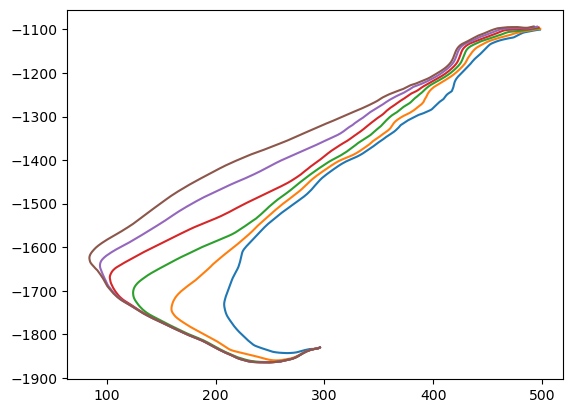

In [95]:
# Convert the flowline data from m to km
ziFlowlines['geometry_km'] = ziFlowlines['geometry'].apply(lambda geom: geom.xy)
ziFlowlines['geometry_km'] = ziFlowlines['geometry_km'].apply(lambda xy: (np.array(xy[0]) / 1000, np.array(xy[1]) / 1000))

# Plot the flowlines
for flowline_km in ziFlowlines['geometry_km']:
    plt.plot(flowline_km[0], flowline_km[1])

In [96]:
ziVelSeries

<xarray.Dataset> Size: 10kB
Dimensions:           (time: 425, x: 301, y: 301)
Coordinates:
    band              <U2 8B ...
  * x                 (x) float64 2kB 4.4e+05 4.402e+05 ... 4.998e+05 5e+05
    epsg              int64 8B ...
    name              <U4 16B ...
    _FillValue        float64 8B ...
  * y                 (y) float64 2kB -1.08e+06 -1.08e+06 ... -1.14e+06
  * time              (time) datetime64[ns] 3kB 2015-01-30T12:00:00 ... 2024-...
Data variables:
    cleaned_velocity  (time) float32 2kB ...

## 2. Convert linestrings to arrays of x and y points

Here we convert the flowlines to numpy arrays. Then, we select the flowline's (x, y) points from the overall dataset by interpolation and add these values to a new dataset. The new dataset, `combined_flowline_velocity_ds` contains the time series values for each flowline.

In [97]:
# Assuming `ziVelSeries` is the dataset with dimensions (time, x, y) 
# and `ziFlowlines.geometry` contains multiple flowlines

# Initialize a list to store the interpolated datasets for each flowline
flowline_datasets = []

# Loop over each flowline in ziFlowlines.geometry
for i, line in enumerate(iterable=ziFlowlines.geometry):
    # Extract x and y coordinates for the current flowline
    flowline_x = np.array([pt[0] for pt in ziFlowlines['geometry_km'][i]])
    flowline_y = np.array([pt[1] for pt in ziFlowlines['geometry_km'][i]])
        
    # Grab the value at the point on the flowline
    interpolated_velocity = ziVelSeries.sel(
        x=xr.DataArray(flowline_x, dims="points"),
        y=xr.DataArray(flowline_y, dims="points"),
        method="nearest"
    )["cleaned_velocity"]

    # Create a new Dataset for the interpolated flowline data
    flowline_velocity_ds = xr.Dataset(
        {
            "velocity": interpolated_velocity
        },
        coords={
            "time": ziVelSeries.time,               # Time coordinates from original dataset
            "points": np.arange(len(flowline_x)),    # Index each point along the flowline
            "x": ("points", flowline_x),             # x-coordinates of each point
            "y": ("points", flowline_y)              # y-coordinates of each point
        },
        attrs={"flowline_id": i}  # Optional: add an attribute to label each flowline
    )
    
    # Append the dataset to the list
    flowline_datasets.append(flowline_velocity_ds)

# Combine all flowline datasets into a single xarray Dataset with a new "flowline" dimension
combined_flowline_velocity_ds = xr.concat(flowline_datasets, dim="flowline")

# Display the combined dataset structure
print(combined_flowline_velocity_ds)


<xarray.Dataset> Size: 14kB
Dimensions:     (time: 425, flowline: 6, points: 2)
Coordinates:
    band        <U2 8B 'vv'
    epsg        int64 8B 3413
    name        <U4 16B 'temp'
    _FillValue  float64 8B -1.0
  * time        (time) datetime64[ns] 3kB 2015-01-30T12:00:00 ... 2024-04-18T...
  * points      (points) int64 16B 0 1
    x           (flowline, points) float64 96B 497.8 -1.1e+03 ... -1.093e+03
    y           (flowline, points) float64 96B 497.6 -1.1e+03 ... -1.093e+03
Dimensions without coordinates: flowline
Data variables:
    velocity    (flowline, time) float32 10kB 1.136e+03 1.041e+03 ... 1.186e+03
Attributes:
    flowline_id:  0


Convert the Xarray dataset to a Pandas dataframe for use with Pycaret's hyperparameter testing capabilities.

In [98]:
combined_flowline_velocity_df = combined_flowline_velocity_ds.to_dataframe().reset_index()
combined_flowline_velocity_df

,time,flowline,points,band,epsg,name,_FillValue,velocity,x,y
0,2015-01-30 12:00:00,0,0,vv,3413,temp,-1.0,1135.628052,497.822495,497.572495
1,2015-01-30 12:00:00,0,1,vv,3413,temp,-1.0,1135.628052,-1100.444834,-1100.490358
2,2015-01-30 12:00:00,1,0,vv,3413,temp,-1.0,1135.628052,498.154637,497.904637
3,2015-01-30 12:00:00,1,1,vv,3413,temp,-1.0,1135.628052,-1098.438063,-1098.497794
4,2015-01-30 12:00:00,2,0,vv,3413,temp,-1.0,1135.628052,496.710341,496.460341
...,...,...,...,...,...,...,...,...,...,...
5095,2024-04-18 12:00:00,3,1,vv,3413,temp,-1.0,1185.645996,-1095.140529,-1095.199534
5096,2024-04-18 12:00:00,4,0,vv,3413,temp,-1.0,1185.645996,495.177218,494.927218
5097,2024-04-18 12:00:00,4,1,vv,3413,temp,-1.0,1185.645996,-1093.630355,-1093.726953
5098,2024-04-18 12:00:00,5,0,vv,3413,temp,-1.0,1185.645996,492.086096,491.836096


In [99]:
combined_flowline_velocity_df.to_csv('../data/clean/Combined_Flowline_Velocity.csv')